In [1]:
import collections
import itertools
import random
import copy

import cirq
import sympy
import numpy as np
import tensorflow_quantum as tfq
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def create_layer(qubits, layer_id):
    symbols = [sympy.Symbol(layer_id + '-' + str(i)) for i in range(len(qubits))]
    gate_set = [cirq.rx, cirq.ry, cirq.rz]

    gates = []
    symbol_gates = []
    for i, q in enumerate(qubits):
        chosen_gate = random.choice(gate_set)
        gates.append(chosen_gate(0)(q))
        symbol_gates.append(chosen_gate(symbols[i])(q))

    for control, target in zip(qubits, qubits[1:]):
        gates.append(cirq.CZ(control, target))
        symbol_gates.append(cirq.CZ(control, target))

    return gates, symbol_gates, symbols

In [3]:
def reduce_image(x):
    x = tf.reshape(x, [1, 28, 28, 1])
    x = tf.image.resize(x, [4, 4])
    x = tf.reshape(x, [4, 4])
    x = x / 255
    return x.numpy()

def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    for x, y in zip(xs, ys):
        mapping[str(x)].add(y)

    return zip(*((x, y) for x, y in zip(xs, ys) if len(mapping[str(x)]) == 1))

def convert_to_circuit(image):
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(1, len(values))
    circuit = cirq.Circuit()

    for i, value in enumerate(values):
        if value > 0.5:
            circuit.append(cirq.X(qubits[i]))

    return circuit

def convert_label(y):
    if y == 3:
        return 1.0
    else:
        return -1.0


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_train))

x_train, y_train = zip(*((x, y) for x, y in zip(x_train, y_train) if y in [3, 6]))
x_test, y_test = zip(*((x, y) for x, y in zip(x_test, y_test) if y in [3, 6]))

x_train = [reduce_image(x) for x in x_train]
x_test = [reduce_image(x) for x in x_test]

x_train, y_train = remove_contradicting(x_train, y_train)
x_test, y_test = remove_contradicting(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

x_train = [convert_to_circuit(x) for x in x_train]
x_test = [convert_to_circuit(x) for x in x_test]

y_train = [convert_label(y) for y in y_train]
y_test = [convert_label(y) for y in y_test]

Number of original training examples: 60000
Number of original test examples: 60000
Number of filtered training examples: 11520
Number of filtered test examples: 1906


In [4]:
# increase for more accurate results
NUM_EXAMPLES = 128
x_train = x_train[:NUM_EXAMPLES]
y_train = y_train[:NUM_EXAMPLES]

x_train = tfq.convert_to_tensor(x_train)
x_test = tfq.convert_to_tensor(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

### Phase I

In [5]:
n_qubits = 6
n_layer_steps = 5
n_layers_to_add = 2
data_qubits = cirq.GridQubit.rect(1, n_qubits)
readout = cirq.GridQubit(0, n_qubits-1)

symbols = []
layers = []
symbol_layers = []
weights = []

training_history = []

for layer_id in range(n_layer_steps):
    print("\nLayer:", layer_id)
    circuit = cirq.Circuit()
    for i in range(n_layers_to_add):
        layer, symbol_layer, layer_symbols = create_layer(data_qubits, f'layer_{layer_id}_{i}')
        layers.append(layer)
        symbol_layers.append(symbol_layer)
        symbols.append(layer_symbols)

    circuit += symbol_layers

    # prepare the readout qubit
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    circuit.append(cirq.X(readout))
    readout_op = cirq.Z(readout)

    # setup the Keras model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string))
    model.add(
        tfq.layers.PQC(
            model_circuit=circuit,
            operators=readout_op,
            differentiator=tfq.differentiators.ParameterShift(),
            initializer=tf.keras.initializers.Zeros))

    print(model.summary())

    model.compile(loss=tf.keras.losses.squared_hinge,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

    # set parameters to 0 for new layers
    model.set_weights([np.pad(weights, (0, n_qubits*n_layers_to_add))])

    model.fit(x_train,
              y_train,
              batch_size=128,
              epochs=20,
              verbose=2,
              validation_data=(x_test, y_test))

    qnn_results = model.evaluate(x_test, y_test)
    training_history.append(qnn_results)

    weights = model.get_weights()[0]


Layer: 0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
Instructions for updating:
Use fn_output_signature instead
1/1 - 1s - loss: 1.0000 - val_loss: 1.0000
Epoch 2/20
1/1 - 1s - loss: 1.0000 - val_loss: 1.0000
Epoch 3/20
1/1 - 1s - loss: 1.0000 - val_loss: 1.0000
Epoch 4/20
1/1 - 1s - loss: 1.0000 - val_loss: 1.0000
Epoch 5/20
1/1 - 0s - loss: 1.0000 - val_loss: 1.0000
Epoch 6/20
1/1 - 0s - loss: 1.0000 - val_loss: 1.0000
Epoch 7/20
1/1 - 0s - loss: 1.0000 - val_loss: 1.0000
Epoch 8/20
1/1 - 0s - loss: 1.0000 - val_loss: 1.0000
Epoch 9/20
1/1 - 0s - loss: 1.0000 - val_loss: 1.0000
Epoch 10/20
1/1 - 0s - loss: 1.0000 - val_loss: 1.0000
Epoch 11/20
1/1 - 0s - loss: 1.0000 - v

Epoch 15/20
1/1 - 2s - loss: 0.8770 - val_loss: 0.8151
Epoch 16/20
1/1 - 2s - loss: 0.8770 - val_loss: 0.8132
Epoch 17/20
1/1 - 2s - loss: 0.8768 - val_loss: 0.8104
Epoch 18/20
1/1 - 2s - loss: 0.8766 - val_loss: 0.8076
Epoch 19/20
1/1 - 2s - loss: 0.8766 - val_loss: 0.8055
Epoch 20/20
1/1 - 2s - loss: 0.8768 - val_loss: 0.8047
60/60 [==============================] - 1s 25ms/step - loss: 0.8047


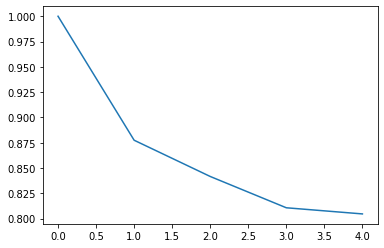

In [6]:
plt.plot(training_history)

### Phase II

In [7]:
partition_percentage = 0.5
partition_size = int(n_layer_steps*n_layers_to_add*partition_percentage)
n_partition_weights = partition_size*n_qubits
n_sweeps = 2

def train_partition(circuit, trained_weights):
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    circuit.append(cirq.X(readout))

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string))
    model.add(
        tfq.layers.PQC(
            model_circuit=circuit,
            operators=readout_op,
            differentiator=tfq.differentiators.ParameterShift(),
            initializer=tf.keras.initializers.Zeros))

    model.compile(loss=tf.keras.losses.squared_hinge,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

    print(model.summary())

    model.set_weights([trained_weights])
    model.fit(x_train,
              y_train,
              batch_size=128,
              epochs=20,
              verbose=1,
              validation_data=(x_test, y_test))

    part_weights = model.get_weights()[0]

    qnn_results = model.evaluate(x_test, y_test)
    training_history.append(qnn_results)

    return part_weights

print("\nSweep over partitions\n")
for sweep in range(n_sweeps):
    # configure and train first partition
    print("\nSweep {}, partition 1\n".format(sweep+1))

    trained_weights = weights[:n_partition_weights]
    untrained_weights = list(copy.copy(weights[n_partition_weights:][::-1]))
    untrained_layers = layers[partition_size:]

    # We can't alter a gate's parameter directly after it was initialized,
    # so we simply initialize a new gate with the new parameter by using
    # a slightly ugly hack to determine the gate type.
    for l in untrained_layers:
        for i, g in enumerate(l):
            if str(g)[:2] == 'Rx':
                l[i] = cirq.rx(untrained_weights.pop())(g.qubits[0])
            elif str(g)[:2] == 'Ry':
                l[i] = cirq.ry(untrained_weights.pop())(g.qubits[0])
            elif str(g)[:2] == 'Rz':
                l[i] = cirq.rz(untrained_weights.pop())(g.qubits[0])

    trained_circuit = cirq.Circuit()
    trained_circuit += symbol_layers[:partition_size]
    trained_circuit += untrained_layers
    part_weights = train_partition(trained_circuit, trained_weights)
    weights[:n_partition_weights] = part_weights

    # configure and train second partition
    print("\nSweep {}, partition 2\n".format(sweep+1))

    trained_weights = weights[n_partition_weights:]
    untrained_weights = list(copy.copy(weights[:n_partition_weights][::-1]))
    untrained_layers = layers[:partition_size]
    for l in untrained_layers:
        for i, g in enumerate(l):
            if str(g)[:2] == 'Rx':
                l[i] = cirq.rx(untrained_weights.pop())(g.qubits[0])
            elif str(g)[:2] == 'Ry':
                l[i] = cirq.ry(untrained_weights.pop())(g.qubits[0])
            elif str(g)[:2] == 'Rz':
                l[i] = cirq.rz(untrained_weights.pop())(g.qubits[0])

    trained_circuit = cirq.Circuit()
    trained_circuit += untrained_layers
    trained_circuit += symbol_layers[partition_size:]

    part_weights = train_partition(trained_circuit, trained_weights)
    weights[n_partition_weights:] = part_weights


Sweep over partitions


Sweep 1, partition 1

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_5 (PQC)                  (None, 1)                 30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.8769 - val_loss: 0.8119
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 0.8767 - val_loss: 0.8132
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 0.8768 - val_loss: 0.8109
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 0.8767 - val_loss: 0.8080
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 0.8766 - val_loss: 0.8062
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 0.8767 - val_loss: 0.8061
Epoch 7/20
1/1 [==============

1/1 [==============================] - 2s 2s/step - loss: 0.8767 - val_loss: 0.8131
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 0.8768 - val_loss: 0.8158
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 0.8771 - val_loss: 0.8146
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 0.8770 - val_loss: 0.8116
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 0.8767 - val_loss: 0.8082
Epoch 8/20
1/1 [==============================] - 2s 2s/step - loss: 0.8766 - val_loss: 0.8057
Epoch 9/20
1/1 [==============================] - 2s 2s/step - loss: 0.8768 - val_loss: 0.8047
Epoch 10/20
1/1 [==============================] - 2s 2s/step - loss: 0.8769 - val_loss: 0.8050
Epoch 11/20
1/1 [==============================] - 2s 2s/step - loss: 0.8768 - val_loss: 0.8064
Epoch 12/20
1/1 [==============================] - 2s 2s/step - loss: 0.8767 - val_loss: 0.8084
Epoch 13/20
1/1 [==============================] - 2s 2s/s

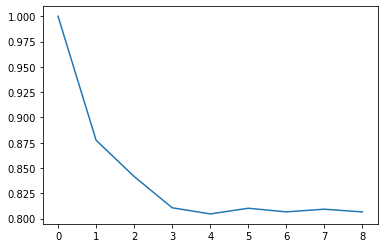

In [8]:
plt.plot(training_history)